In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
import kagglehub as kh
from kagglehub import KaggleDatasetAdapter
from sklearn.discriminant_analysis import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from plotnine import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

path = kh.dataset_download("uciml/msd-audio-features")
print("Path to dataset files:", path)
data_by_decade = pd.read_csv(path + "/year_prediction.csv")
# data_by_ear doesn't have the year labels squashed into decades
data_by_year = pd.read_csv(path + "/year_prediction.csv")

# check for NA
data_dropped = data_by_decade.dropna()
if len(data_dropped) == len(data_by_decade):
    print("No NA")


Path to dataset files: /home/koris/.cache/kagglehub/datasets/uciml/msd-audio-features/versions/1
No NA


In [ ]:


def convert_year(year):
    year_str = str(int(year["label"]))
    year_str = year_str[:-1] + '0'
    year_str += 's'
    return year_str

data_by_decade["label"] = data_by_decade.apply(convert_year, axis=1)
data_by_decade["label"].value_counts()


label
2000s    299003
1990s    124713
1980s     41814
1970s     24745
1960s     11739
2010s      9397
1950s      3102
1940s       356
1930s       252
1920s       224
Name: count, dtype: int64

In [ ]:
# label
# TimbreAvg(1 - 12)
# TimberCovariance(1 - 78)
data_sample = data_by_decade.sample(n=10000, random_state=1)
data_by_decade.head()

,label,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,...,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
0,2000s,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2000s,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2000s,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2000s,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2000s,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Text(0.5, 0, 'Year')

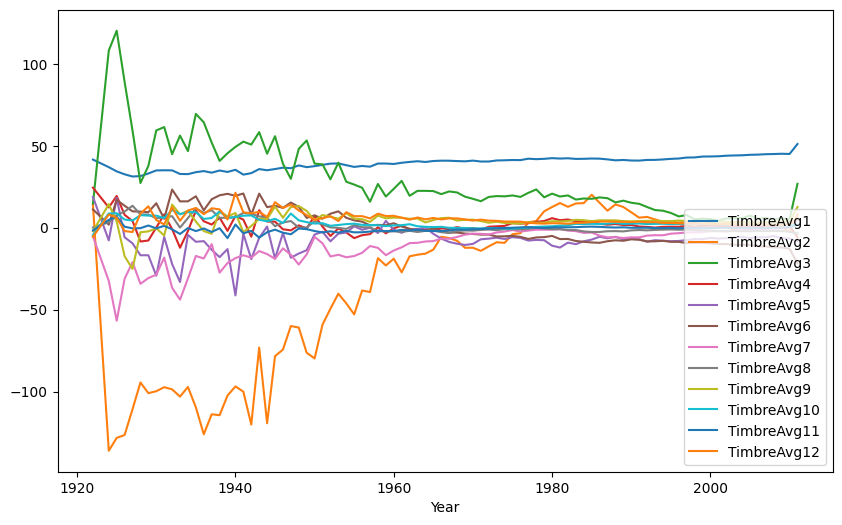

In [ ]:
plt.figure(figsize=(10, 6))

ta1_means_by_decade = data_by_year.groupby('label')['TimbreAvg1'].mean()
ta2_means_by_decade = data_by_year.groupby('label')['TimbreAvg2'].mean()
ta3_means_by_decade = data_by_year.groupby('label')['TimbreAvg3'].mean()
ta4_means_by_decade = data_by_year.groupby('label')['TimbreAvg4'].mean()
ta5_means_by_decade = data_by_year.groupby('label')['TimbreAvg5'].mean()
ta6_means_by_decade = data_by_year.groupby('label')['TimbreAvg6'].mean()
ta7_means_by_decade = data_by_year.groupby('label')['TimbreAvg7'].mean()
ta8_means_by_decade = data_by_year.groupby('label')['TimbreAvg8'].mean()
ta9_means_by_decade = data_by_year.groupby('label')['TimbreAvg9'].mean()
ta10_means_by_decade = data_by_year.groupby('label')['TimbreAvg10'].mean()
ta11_means_by_decade = data_by_year.groupby('label')['TimbreAvg11'].mean()
ta12_means_by_decade = data_by_year.groupby('label')['TimbreAvg12'].mean()

plt.plot(ta1_means_by_decade, label='TimbreAvg1')
plt.plot(ta2_means_by_decade, label='TimbreAvg2')
plt.plot(ta3_means_by_decade, label='TimbreAvg3')
plt.plot(ta4_means_by_decade, label='TimbreAvg4')
plt.plot(ta5_means_by_decade, label='TimbreAvg5')
plt.plot(ta6_means_by_decade, label='TimbreAvg6')
plt.plot(ta7_means_by_decade, label='TimbreAvg7')
plt.plot(ta8_means_by_decade, label='TimbreAvg8')
plt.plot(ta9_means_by_decade, label='TimbreAvg9')
plt.plot(ta10_means_by_decade, label='TimbreAvg10')
plt.plot(ta11_means_by_decade, label='TimbreAvg11')
plt.plot(ta12_means_by_decade, label='TimbreAvg12')

plt.legend(loc='lower right')
plt.xlabel('Year')


Text(0.5, 0, 'Year')

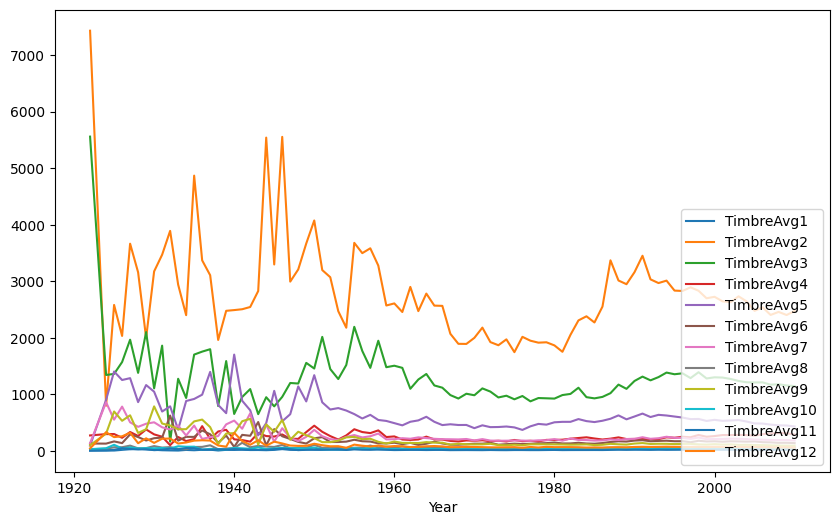

In [65]:
plt.figure(figsize=(10, 6))

ta1_means_by_decade = data_by_year.groupby('label')['TimbreAvg1'].var()
ta2_means_by_decade = data_by_year.groupby('label')['TimbreAvg2'].var()
ta3_means_by_decade = data_by_year.groupby('label')['TimbreAvg3'].var()
ta4_means_by_decade = data_by_year.groupby('label')['TimbreAvg4'].var()
ta5_means_by_decade = data_by_year.groupby('label')['TimbreAvg5'].var()
ta6_means_by_decade = data_by_year.groupby('label')['TimbreAvg6'].var()
ta7_means_by_decade = data_by_year.groupby('label')['TimbreAvg7'].var()
ta8_means_by_decade = data_by_year.groupby('label')['TimbreAvg8'].var()
ta9_means_by_decade = data_by_year.groupby('label')['TimbreAvg9'].var()
ta10_means_by_decade = data_by_year.groupby('label')['TimbreAvg10'].var()
ta11_means_by_decade = data_by_year.groupby('label')['TimbreAvg11'].var()
ta12_means_by_decade = data_by_year.groupby('label')['TimbreAvg12'].var()

plt.plot(ta1_means_by_decade, label='TimbreAvg1')
plt.plot(ta2_means_by_decade, label='TimbreAvg2')
plt.plot(ta3_means_by_decade, label='TimbreAvg3')
plt.plot(ta4_means_by_decade, label='TimbreAvg4')
plt.plot(ta5_means_by_decade, label='TimbreAvg5')
plt.plot(ta6_means_by_decade, label='TimbreAvg6')
plt.plot(ta7_means_by_decade, label='TimbreAvg7')
plt.plot(ta8_means_by_decade, label='TimbreAvg8')
plt.plot(ta9_means_by_decade, label='TimbreAvg9')
plt.plot(ta10_means_by_decade, label='TimbreAvg10')
plt.plot(ta11_means_by_decade, label='TimbreAvg11')
plt.plot(ta12_means_by_decade, label='TimbreAvg12')

plt.legend(loc='lower right')
plt.xlabel('Year')


## PCA

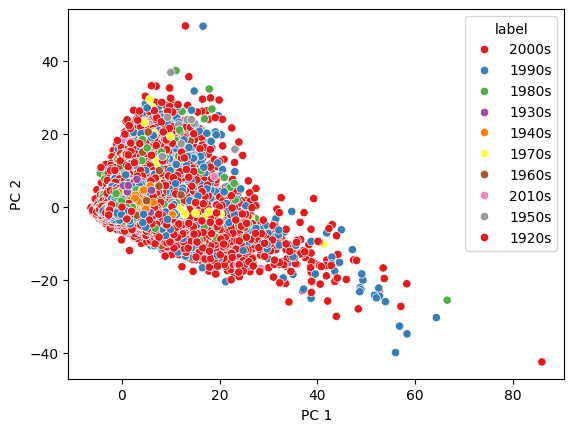

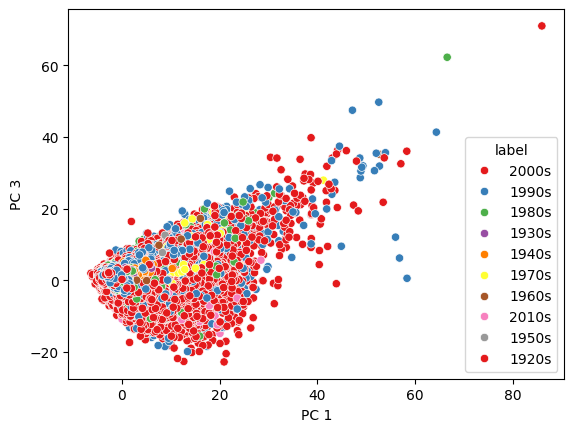

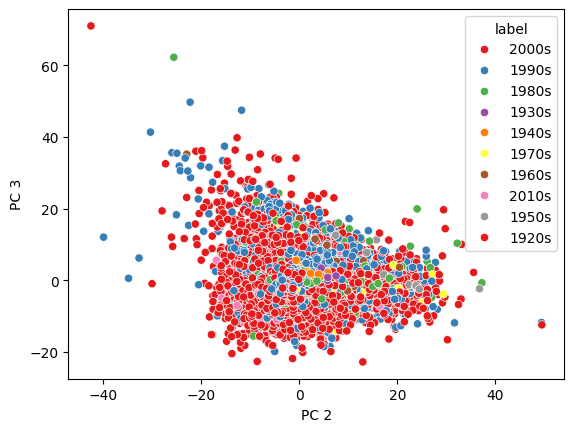

In [ ]:
NUM_COMPONENTS = 9
pca = PCA(n_components=NUM_COMPONENTS)

scaler = StandardScaler()

data_no_label = data_by_decade.drop('label', axis=1)
scaled_data = scaler.fit_transform(data_no_label)
pca_data = pca.fit_transform(scaled_data)
pca_data_raw = pca_data.copy()
pca_data = pd.DataFrame(pca_data, columns=[f'PC {i+1}' for i in range(NUM_COMPONENTS)])
pca_data['label'] = data_by_decade['label']

sns.scatterplot(data=pca_data, x='PC 1', y='PC 2', hue='label', palette='Set1')
plt.show()

sns.scatterplot(data=pca_data, x='PC 1', y='PC 3', hue='label', palette='Set1')
plt.show()

sns.scatterplot(data=pca_data, x='PC 2', y='PC 3', hue='label', palette='Set1') 
plt.show()

## Scree Plot (for PC count)

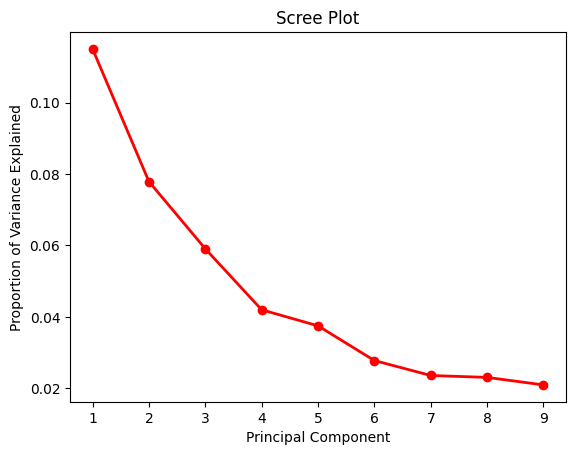

In [6]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

## K-means clustering

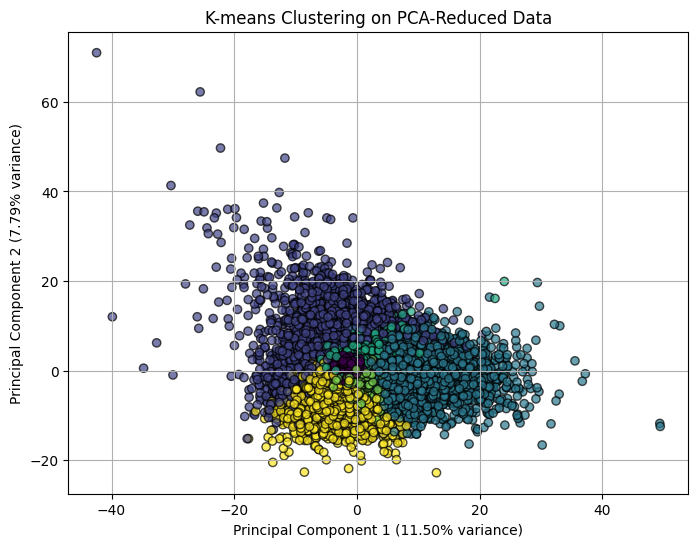

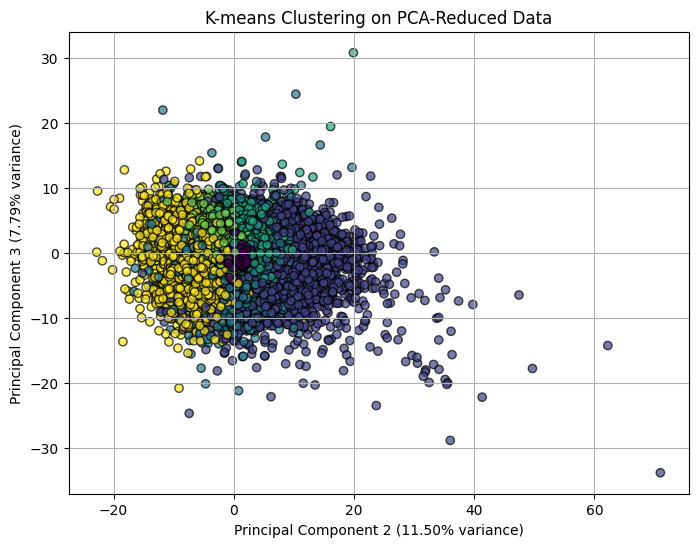

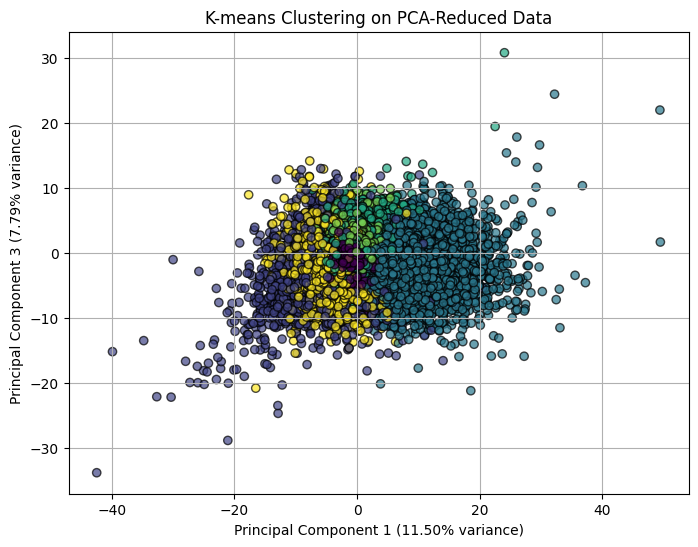

In [7]:
explained_variance = pca.explained_variance_ratio_
kmeans = KMeans(n_clusters=6, random_state=30)
s = kmeans.fit(pca_data_raw)
clusters = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(
    pca_data_raw[:, 1], pca_data_raw[:, 2], c=clusters, alpha=0.7, edgecolor='k'  
)

plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}% variance)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}% variance)")
plt.title("K-means Clustering on PCA-Reduced Data")
plt.grid()
plt.show();

plt.figure(figsize=(8, 6))
plt.scatter(
    pca_data_raw[:, 2], pca_data_raw[:, 3], c=clusters, alpha=0.7, edgecolor='k' 
)

plt.xlabel(f"Principal Component 2 ({explained_variance[0]*100:.2f}% variance)")
plt.ylabel(f"Principal Component 3 ({explained_variance[1]*100:.2f}% variance)")
plt.title("K-means Clustering on PCA-Reduced Data")
plt.grid()
plt.show();

plt.figure(figsize=(8, 6))
plt.scatter(
    pca_data_raw[:, 1], pca_data_raw[:, 3], c=clusters, alpha=0.7, edgecolor='k' 
)

plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}% variance)")
plt.ylabel(f"Principal Component 3 ({explained_variance[1]*100:.2f}% variance)")
plt.title("K-means Clustering on PCA-Reduced Data")
plt.grid()
plt.show();


## T-SNE

/tmp/ipykernel_1608913/4015804856.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/tmp/ipykernel_1608913/4015804856.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


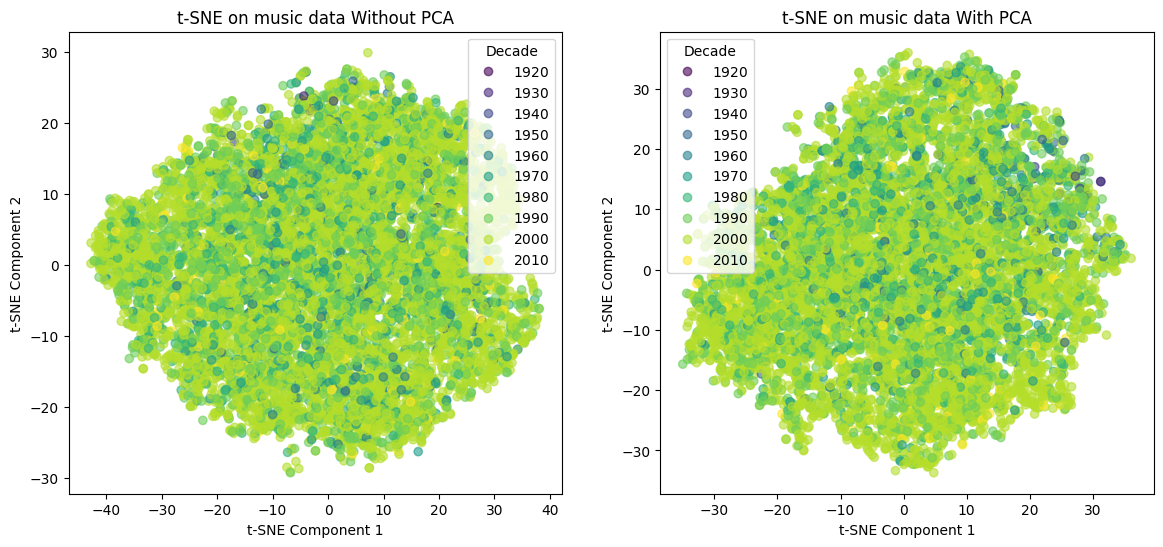

In [ ]:
# T-SNE

data_sampled = data_by_decade.sample(n=10000, random_state=42)
pca_sampled = pca_data.sample(n=10000, random_state=42)

labels_trim = data_sampled["label"]
pca_labels_trim = pca_sampled["label"]
data_sampled = data_sampled.drop(["label"], axis=1)
pca_sampled = pca_sampled.drop(["label"], axis=1)

labels_trim = labels_trim.replace({"2010s": 2010})
labels_trim = labels_trim.replace({"2000s": 2000})
labels_trim = labels_trim.replace({"1990s": 1990})
labels_trim = labels_trim.replace({"1980s": 1980})
labels_trim = labels_trim.replace({"1970s": 1970})
labels_trim = labels_trim.replace({"1960s": 1960})
labels_trim = labels_trim.replace({"1950s": 1950})
labels_trim = labels_trim.replace({"1940s": 1940})
labels_trim = labels_trim.replace({"1930s": 1930})
labels_trim = labels_trim.replace({"1920s": 1920})

pca_labels_trim = pca_labels_trim.replace({"2010s": 2010})
pca_labels_trim = pca_labels_trim.replace({"2000s": 2000})
pca_labels_trim = pca_labels_trim.replace({"1990s": 1990})
pca_labels_trim = pca_labels_trim.replace({"1980s": 1980})
pca_labels_trim = pca_labels_trim.replace({"1970s": 1970})
pca_labels_trim = pca_labels_trim.replace({"1960s": 1960})
pca_labels_trim = pca_labels_trim.replace({"1950s": 1950})
pca_labels_trim = pca_labels_trim.replace({"1940s": 1940})
pca_labels_trim = pca_labels_trim.replace({"1930s": 1930})
pca_labels_trim = pca_labels_trim.replace({"1920s": 1920})

labels_trim = labels_trim.to_list()
pca_labels_trim = pca_labels_trim.to_list()

tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_no_pca = tsne.fit_transform(data_sampled)
tsne_pca = tsne.fit_transform(pca_sampled)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

s1 = ax[0].scatter(tsne_no_pca[:, 0], tsne_no_pca[:, 1], c=labels_trim, cmap="viridis", alpha=0.6)
ax[0].set_title("t-SNE on music data Without PCA")
ax[0].set_xlabel("t-SNE Component 1")
ax[0].set_ylabel("t-SNE Component 2")
ax[0].legend(*s1.legend_elements(), title="Decade")

s2 = ax[1].scatter(tsne_pca[:, 0], tsne_pca[:, 1], c=pca_labels_trim, cmap="viridis", alpha=0.6)
ax[1].set_title("t-SNE on music data With PCA")
ax[1].set_xlabel("t-SNE Component 1")
ax[1].set_ylabel("t-SNE Component 2")
ax[1].legend(*s2.legend_elements(), title="Decade");

plt.show()

In [9]:
# Use feature selection (e.g., Recursive Feature Elimination) or
# regularized models (like LASSO or Ridge regression) to see which timbre characteristics are most predictive.